In [67]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import tracemalloc

In [68]:
file_path = r'C:\Users\Χριστόδουλος\Desktop\ML project\cleaned_energy_data.csv'
df = pd.read_csv(file_path)

In [69]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df.drop(columns=['date'])

df = df.select_dtypes(include=['float64', 'int64', 'int32'])

X = df.drop(columns=["Appliances"])
y = df["Appliances"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

In [71]:
sequence_length = 5
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=sequence_length, batch_size=1)

In [72]:
def gru_model():
    model = Sequential()
    model.add(GRU(units=128, activation="tanh", input_shape=(sequence_length, X_train_scaled.shape[1])))
    model.add(Dropout(0.2))  
    model.add(Dense(1))  
    model.compile(optimizer="adam", loss="mse") 
    return model

In [73]:
gru = gru_model()
gru.summary()
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


start_time = time.time()
tracemalloc.start()

gru = gru_model()
history = gru.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

C:\Users\Χριστόδουλος\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 128)            │        68,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,481 (267.50 KB)

 Trainable params: 68,481 (267.50 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Χριστόδουλος\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0667 - val_loss: 0.0971
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0756 - val_loss: 0.0032
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - val_loss: 0.0154
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0116
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386 - val_loss: 0.0036
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0071


In [74]:
def get_model_predictions(train, test, model):
    y_hat = []
    batch = train[-sequence_length:].reshape((1, sequence_length, 1))
    for i in range(len(test)):
        new_pred = model.predict(batch)[0]
        y_hat.append(new_pred)
        batch = np.append(batch[:, 1:, :], [[new_pred]], axis=1)
    return np.array(y_hat).reshape(-1, 1)

In [75]:
gru_pred = gru.predict(test_generator)
gru_pred_unscaled = target_scaler.inverse_transform(gru_pred)

y_test_aligned = y_test[sequence_length:]

rmse = mean_squared_error(y_test_aligned, gru_pred_unscaled, squared=False)  
mae = mean_absolute_error(y_test_aligned, gru_pred_unscaled) 

y_test_1d = y_test_aligned.flatten() if y_test_aligned.ndim > 1 else y_test_aligned
gru_pred_unscaled_1d = gru_pred_unscaled.flatten() if gru_pred_unscaled.ndim > 1 else gru_pred_unscaled

mape = (abs((y_test_1d - gru_pred_unscaled_1d) / y_test_1d).mean()) * 100    
r2 = r2_score(y_test_aligned, gru_pred_unscaled)                          

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.4f}")
print("Training time (s):", end_time - start_time)
print("Memory usage (Bytes):", current)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 13.0300
MAE: 10.1970
MAPE: 22.41%
R^2: -0.2517
Training time (s): 9.59726858139038
Memory usage (Bytes): 9856972


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


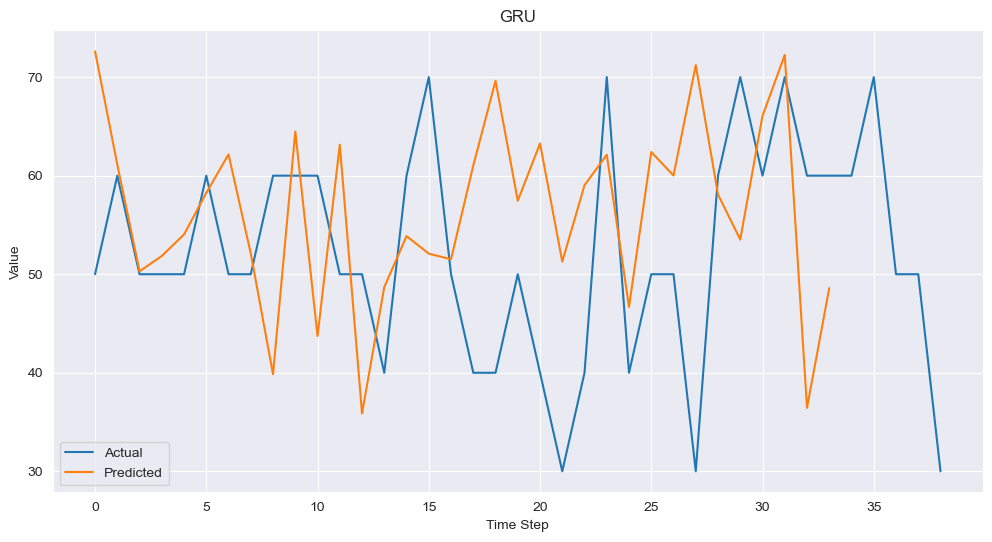

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual') 
plt.plot(gru_pred_unscaled.flatten(), label='Predicted')
plt.title('GRU')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

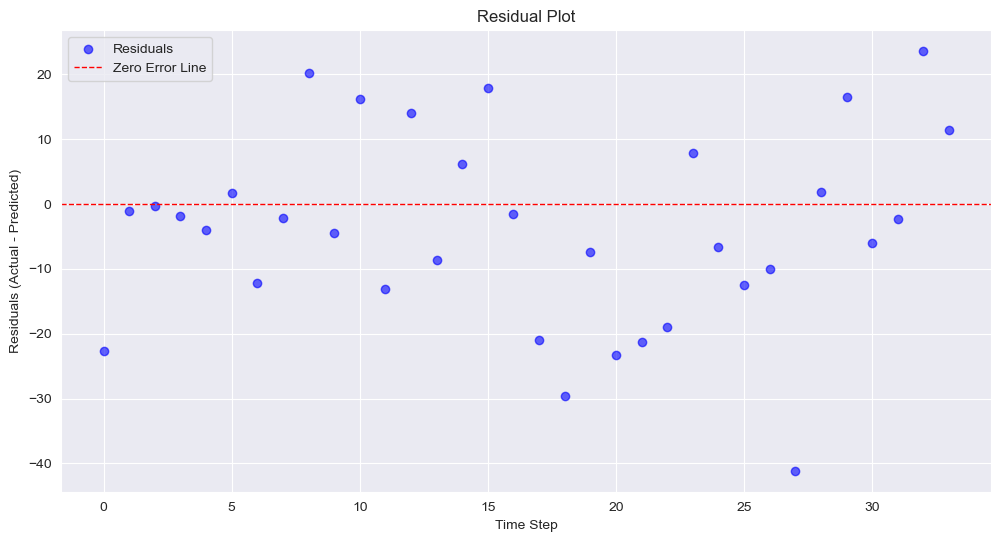

In [77]:
min_length = min(len(y_test.values), len(gru_pred_unscaled.flatten()))
y_test_aligned = y_test.values[:min_length]
gru_pred_aligned = gru_pred_unscaled.flatten()[:min_length]

residuals = y_test_aligned - gru_pred_aligned

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='blue', alpha=0.6, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Error Line')
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()